Even though I throw away the burn-in and thin the samples in `tsunami_1852.py`, but the actual paper shows that we only use the last 5000 samples.
So, that's what I also did in the Hessian estimation here.

In [1]:
from pathlib import Path
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
from corner import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity

from tsunami_1852 import *
from utils import normalize_samples, get_samples_subset
import sensitivity_regression as sr

%matplotlib inline
plt.style.use("default")

# Setup - Extracting values

In [2]:
param_names= list(mcmc_data["samples"].columns)
# These are the labels of the parameters for plotting
param_labels = [
    "Latitude",
    "Longitude",
    "Magnitude",
    r"$\Delta~\log L$",
    r"$\Delta~\log W$",
    "Depth Offset"
]
nparams = len(param_names)
print("Parameters:", param_names)

Parameters: ['latitude', 'longitude', 'magnitude', 'delta_logl', 'delta_logw', 'depth_offset']


## Chains

In [3]:
# Get the chains only as a 3D numpy array, where the axes correspond to walker,
# iteration, and parameters.
npoints_raw = len(mcmc_raw_data["chain0"]["samples"])
chains = np.empty((len(mcmc_raw_data), 24_001, nparams))
for ii, val in enumerate(mcmc_raw_data.values()):
    chains[ii] = val["samples"].to_numpy()
print(chains.shape)

(14, 24001, 6)


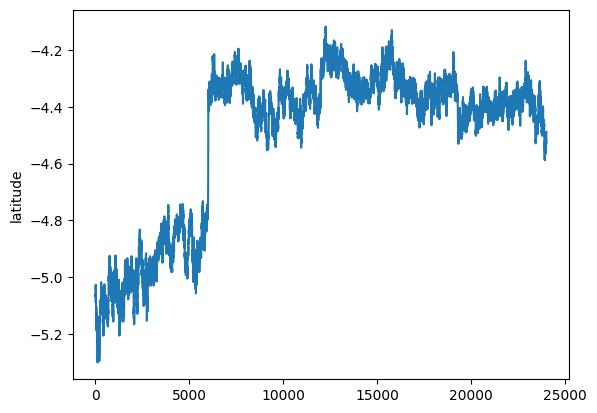

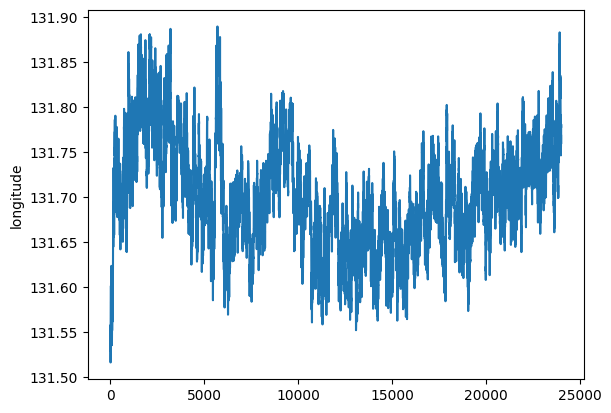

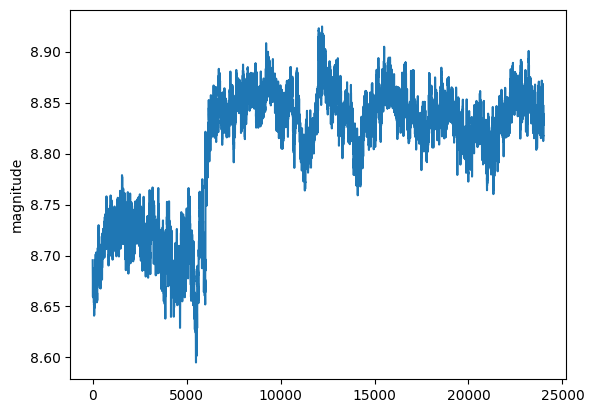

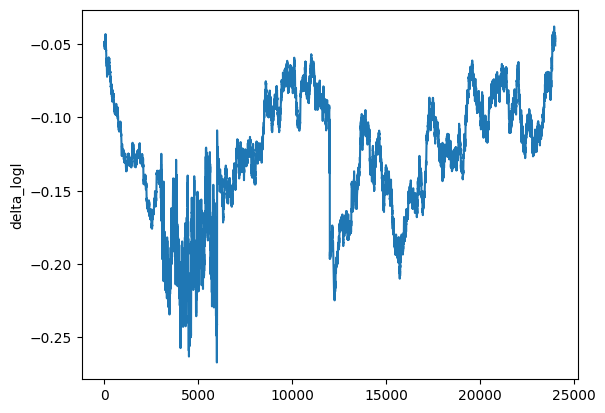

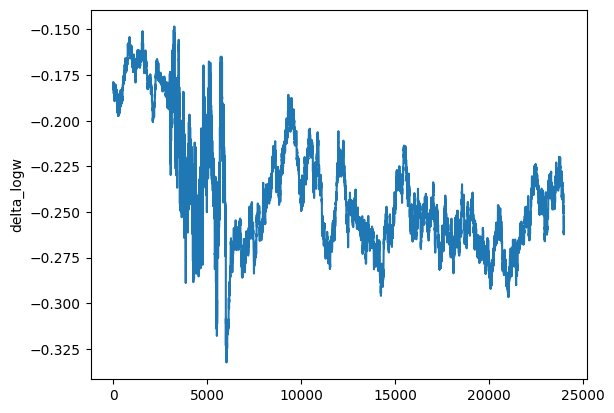

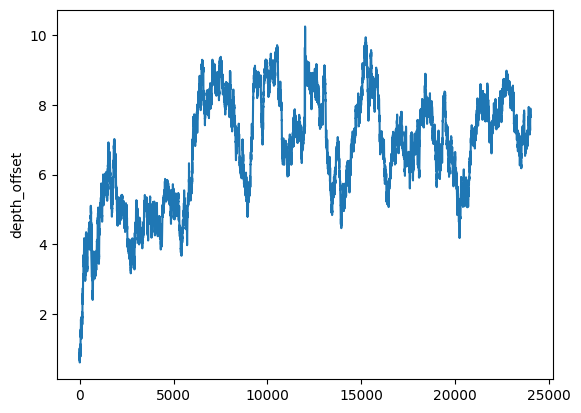

In [4]:
# Plot the mean across the chains for different parameters. These plots should be
# comparable to the blue curves in Figure 4 in the paper.
for pidx, name in enumerate(param_names):
    chains_param = chains[:, :, pidx]
    
    plt.figure()
    plt.plot(np.mean(chains_param, axis=0))
    plt.ylabel(name)
plt.show()

In [5]:
# Get the samples that are used to estimate posterior, i.e., the last 5,000 steps
nsamples_per_chain = 5000
samples = chains[:, -nsamples_per_chain:]
print(samples.shape)

(14, 5000, 6)


## Probabilities

In [6]:
prob_names = ["logprior", "loglikelihood", "logposterior"]

In [7]:
# Get the logprobabilities. There are 3 probabilities we are extracting: prior,
# likelihood, and posterior.
logprobability = np.empty((len(mcmc_raw_data), 24_001, len(prob_names)))
for ii, val in enumerate(mcmc_raw_data.values()):
    logprobability[ii] = val["bayes_data"].to_numpy()
    
# Take only the values used in the paper to estimate the posterior
logprobability_samples = logprobability[:, -nsamples_per_chain:]
print(logprobability.shape)

(14, 24001, 3)


# Derivative estimation of the posterior

In [8]:
# Combine the values across different chains
samples_flatten = samples.reshape((-1, nparams))
logprob_samples_flatten = logprobability_samples.reshape((-1, len(prob_names)))
# Separate logprobabilities
(
    logprior_samples_flatten,
    loglike_samples_flatten,
    logpost_samples_flatten,
) = logprob_samples_flatten.T

In [9]:
# Find the MAP and MLE
idx_map = np.argmax(logpost_samples_flatten)
idx_mle = np.argmax(loglike_samples_flatten)

In [10]:
def compute_J(r, idx_center):
    """Compute the Jacobian of the posterior with respect to sample parameters. The
    first argument specifies the the radius of the hypersphere to use to filter the
    samples that will be used to estimate the derivatives around a point. The second
    argument gives the index of the center point.
    
    To filter the samples, we first normalize the samples of the sample parameters,
    i.e., shifting them by the mean then scale them by the standard deviation. Then,
    we draw a hypersphere with radius :math:`r` around the point where we want to
    estimate the derivative, and we only extract the points inside the hypersphere.
    """
    # Normalized samples
    samples_normalized = normalize_samples(
        samples_flatten, samples_flatten[idx_center], np.std(samples_flatten, axis=0)
    )

    # Only use points within a hypersphere in samples space
    center = samples_normalized[idx_center]
    samples_norm_subset, idx_subset = get_samples_subset(samples_normalized, center, r)
    # print(len(idx_subset))

    # Estimate Jacobian and Hessian
    X0 = center
    Q0 = logpost_samples_flatten[idx_center]
    X = samples_norm_subset
    Q = logpost_samples_flatten[idx_subset]

    # Estimation for logpost_samples_flatten
    J = sr.first_order(X0, Q0, X, Q)
    return J[0]


def compute_J_H(r, idx_center):
    """Similar to ``compute_J``, but we will also compute the Hessian."""
    # Normalized samples
    samples_normalized = normalize_samples(
        samples_flatten, samples_flatten[idx_center], np.std(samples_flatten, axis=0)
    )

    # Only use points within a hypersphere in samples space
    center = samples_normalized[idx_center]
    samples_norm_subset, idx_subset = get_samples_subset(samples_normalized, center, r)
    # print(len(idx_subset))

    # Estimate Jacobian and Hessian
    X0 = center
    Q0 = logpost_samples_flatten[idx_center]
    X = samples_norm_subset
    Q = logpost_samples_flatten[idx_subset]

    # Estimation for logpost_samples_flatten
    J, H = sr.first_second_order(X0, Q0, X, Q)
    
    # Covariance
    cov = np.cov(X.T)
    return J[0], H[0], cov

## Derivative estimation around the MAP

In [11]:
# rlist = np.append(0.5, np.arange(10) + 1)[::-1]
rlist = np.linspace(1, 10, 91)[::-1]

J_H_estimate_file = Path("results/J_H_map_1852.pkl")

if J_H_estimate_file.exists():
    with open(J_H_estimate_file, "rb") as f:
        J_H_estimate_dict = pickle.load(f)
else:
    J_H_estimate_dict = {}

for r in tqdm(rlist):
    key = np.round(r, 1)
    if key not in J_H_estimate_dict:
        # try:
        J = compute_J(r, idx_map)
        _, H = compute_J_H(r, idx_map)
        J_H_estimate_dict.update({key: {"jacobian": J, "hessian": H}})
        
        # Export
        with open(J_H_estimate_file, "wb") as f:
            pickle.dump(J_H_estimate_dict, f, protocol=4)
        # except ValueError:
        #     break

100%|███████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 17636.15it/s]


In [12]:
rlist = np.array(list(J_H_estimate_dict))
singvals_J = []
eigvals_H = np.empty((0, nparams))

for r in tqdm(rlist):
    key = np.round(r, 1)
    # Compute the singular values of the Jacobian
    J = J_H_estimate_dict[key]["jacobian"]
    sigma = np.linalg.norm(J)  # We can do this because it is just a vector
    singvals_J = np.append(singvals_J, sigma)
    
    # Compute the eigenvalues of the Hessian
    H = J_H_estimate_dict[key]['hessian']
    lambdas = np.linalg.eigvalsh(H)
    eigvals_H = np.row_stack((eigvals_H, lambdas))

100%|████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 3913.64it/s]


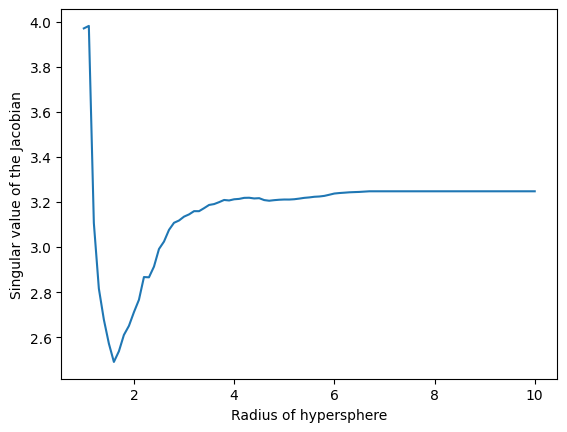

In [13]:
plt.figure()
plt.plot(rlist, singvals_J)
# plt.xticks(np.arange(0, len(singvals_J), 2), rlist[:len(singvals_J):2])
plt.xlabel("Radius of hypersphere")
plt.ylabel("Singular value of the Jacobian")
plt.show()

We know that in theory the singular values of the Jacobian at the MAP points should be zero.
Thus, we take the optimal cutoff radius to be the radius that minimizes the singular values of the Jacobian.

In [14]:
# Optimal radius gives Jacobian that has singular values closest to zero
idx_ropt = np.argmin(singvals_J)
ropt = rlist[idx_ropt]
print(ropt)

1.6


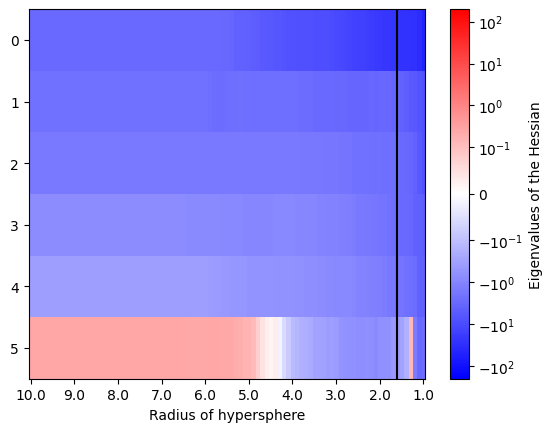

In [15]:
plt.figure()
im = plt.imshow(
    eigvals_H.T,
    norm=mpl.colors.SymLogNorm(linthresh=1e-1, vmin=-2e2, vmax=2e2),
    cmap="bwr",
    aspect="auto"
)
clb = plt.colorbar(im)
plt.axvline(np.argmin(singvals_J), c="k")
plt.xticks(np.arange(0, len(singvals_J), 10), rlist[:len(singvals_J):10])
plt.xlabel("Radius of hypersphere")
clb.set_label("Eigenvalues of the Hessian")
plt.show()

It is also comforting that the Hessian estimated using this cutoff radius is negative definite.
This agrees with the theory that the Hessian at the MAP point should be negative semidefinite.

### Visualize the samples used in the derivative estimation

In [16]:
# Get the index of samples
# Normalized samples
samples_normalized = normalize_samples(
    samples_flatten, samples_flatten[idx_map], np.std(samples_flatten, axis=0)
)

# Only use points within a hypersphere in samples space
center = samples_normalized[idx_map]
samples_norm_subset, idx_subset = get_samples_subset(samples_normalized, center, ropt)
print(len(idx_subset))

10603


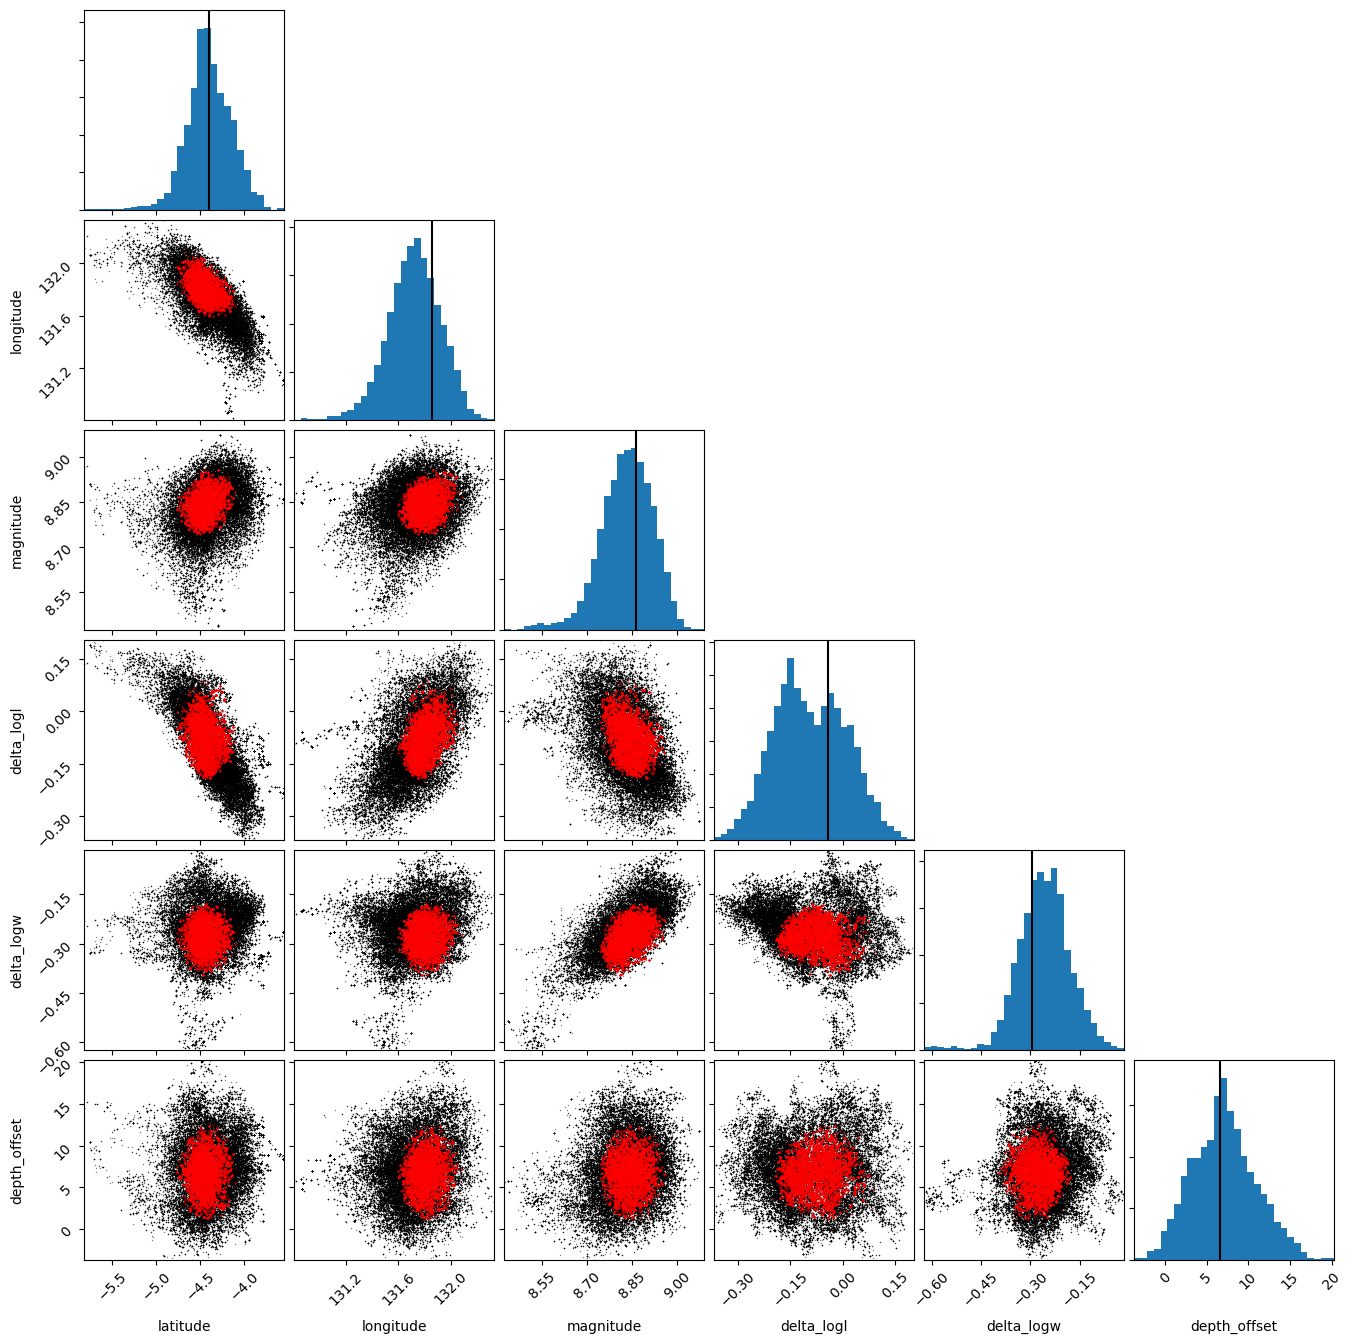

In [17]:
figure = corner(
    samples_flatten,
    labels=param_names,  # Name of parameters
    bins=30,  # Number of bins
    # kwargs for marginal distribution
    hist_kwargs=dict(color="tab:blue", histtype="stepfilled"),
    # kwargs for lower triangular plot(s)
    **dict(
        color="k",  # Color of samples, density, and contours
        plot_density=False,  # Flag to deactivate the density plot
        plot_contours=False,  # Flag to deactivate the contour plot
        data_kwargs=dict(ms=1, alpha=0.5),  # Other kwargs to plot samples
    ),
)

axes = np.array(figure.axes).reshape((nparams, nparams))
for row in range(nparams):
    for col in range(nparams):
        ax = axes[row, col]
        if col < row:
            ax.plot(
                *(samples_flatten[idx_subset][:, [col, row]].T), "r.", ms=1, alpha=0.5
            )
        elif col == row:
            ax.axvline(samples_flatten[idx_map, col], c="k")
plt.show()

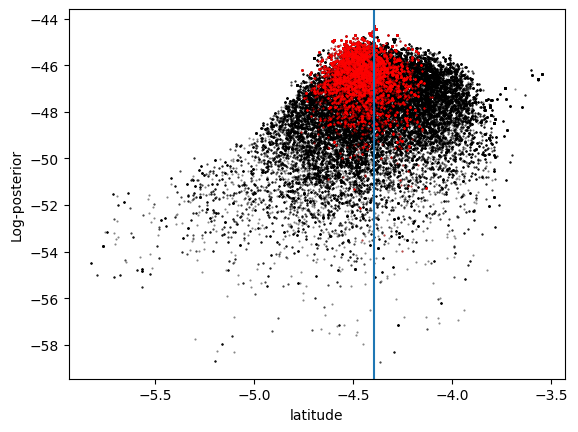

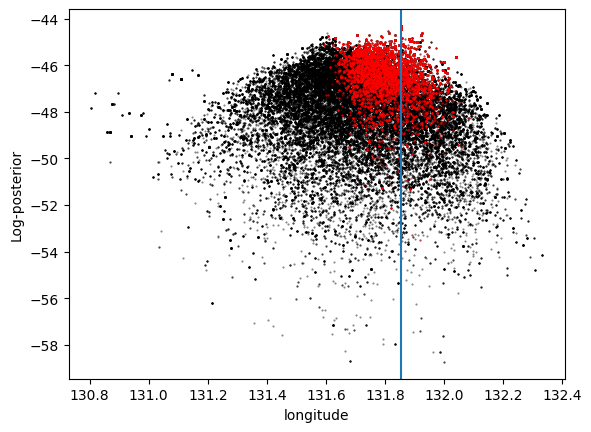

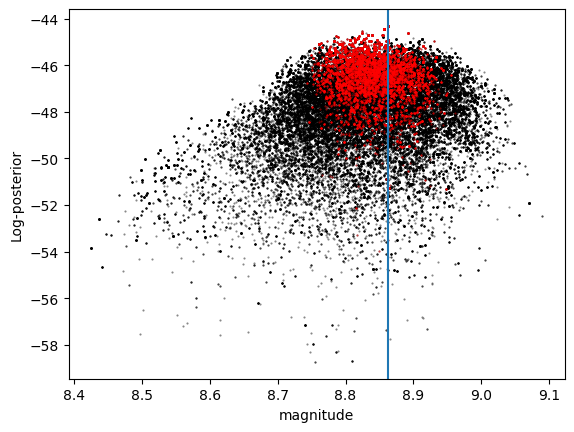

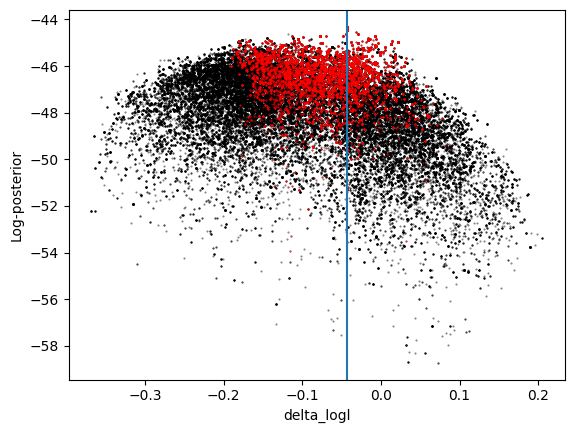

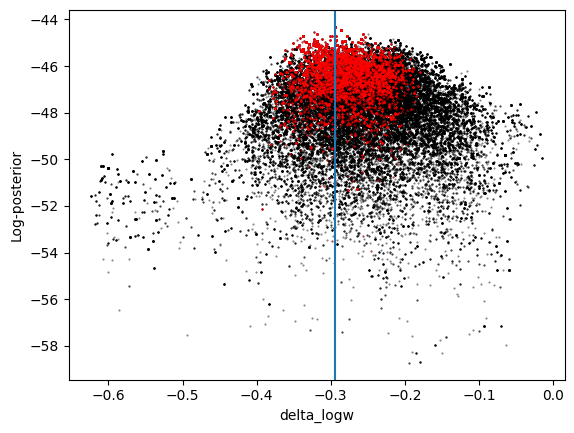

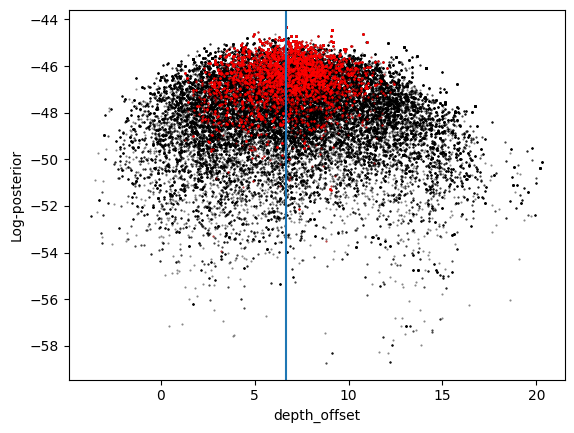

In [18]:
for ii, name in enumerate(param_names):
    plt.figure()
    plt.plot(samples_flatten[:, ii], logpost_samples_flatten, "k.", ms=1, alpha=0.5)
    plt.plot(
        samples_flatten[idx_subset, ii],
        logpost_samples_flatten[idx_subset],
        "r.",
        ms=1,
        alpha=0.5,
    )
    plt.axvline(samples_flatten[idx_map, ii])
    plt.xlabel(name)
    plt.ylabel("Log-posterior")
plt.show()

### Analysis of the estimated derivative

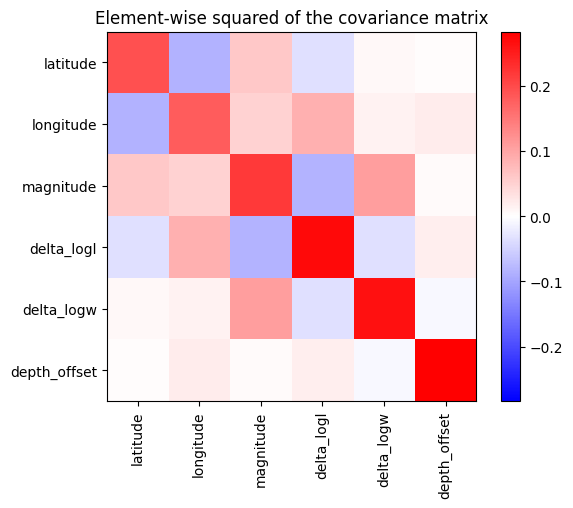

In [19]:
# Take the normalized subset of the samples that are used in the derivative estimation,
# then compute the covariance matrix. If the covariance matrix is close to identity,
# that means the samples that we use in the derivative estimation are pretty symmetric
# in the scaled parameter space. Thus, we can assume that the variation we see in the
# estimated derivative comes mostly from the structure of the posterior, and not from
# how we sample the points.
cov = np.cov(samples_norm_subset.T)

# Visualize the covariance matrix
plt.figure()
plt.title("Element-wise squared of the covariance matrix")
# Color bound
cbound = max([np.max(cov), np.abs(np.min(cov))])
plt.imshow(cov, cmap="bwr", vmin=-cbound, vmax=cbound)
plt.colorbar()
plt.xticks(range(nparams), param_names, rotation=90)
plt.yticks(range(nparams), param_names)
plt.show()

I think this covariance matrix is close enough to an identity matrix.

In [20]:
# Get the Hessian estimated
Hopt = J_H_estimate_dict[ropt]["hessian"]
eigvals, eigvecs = np.linalg.eigh(Hopt)
print("Eigenvalues: \n", eigvals)

Eigenvalues: 
 [-24.98559909  -3.73869773  -2.70283524  -2.64579586  -1.85081228
  -0.43601054]


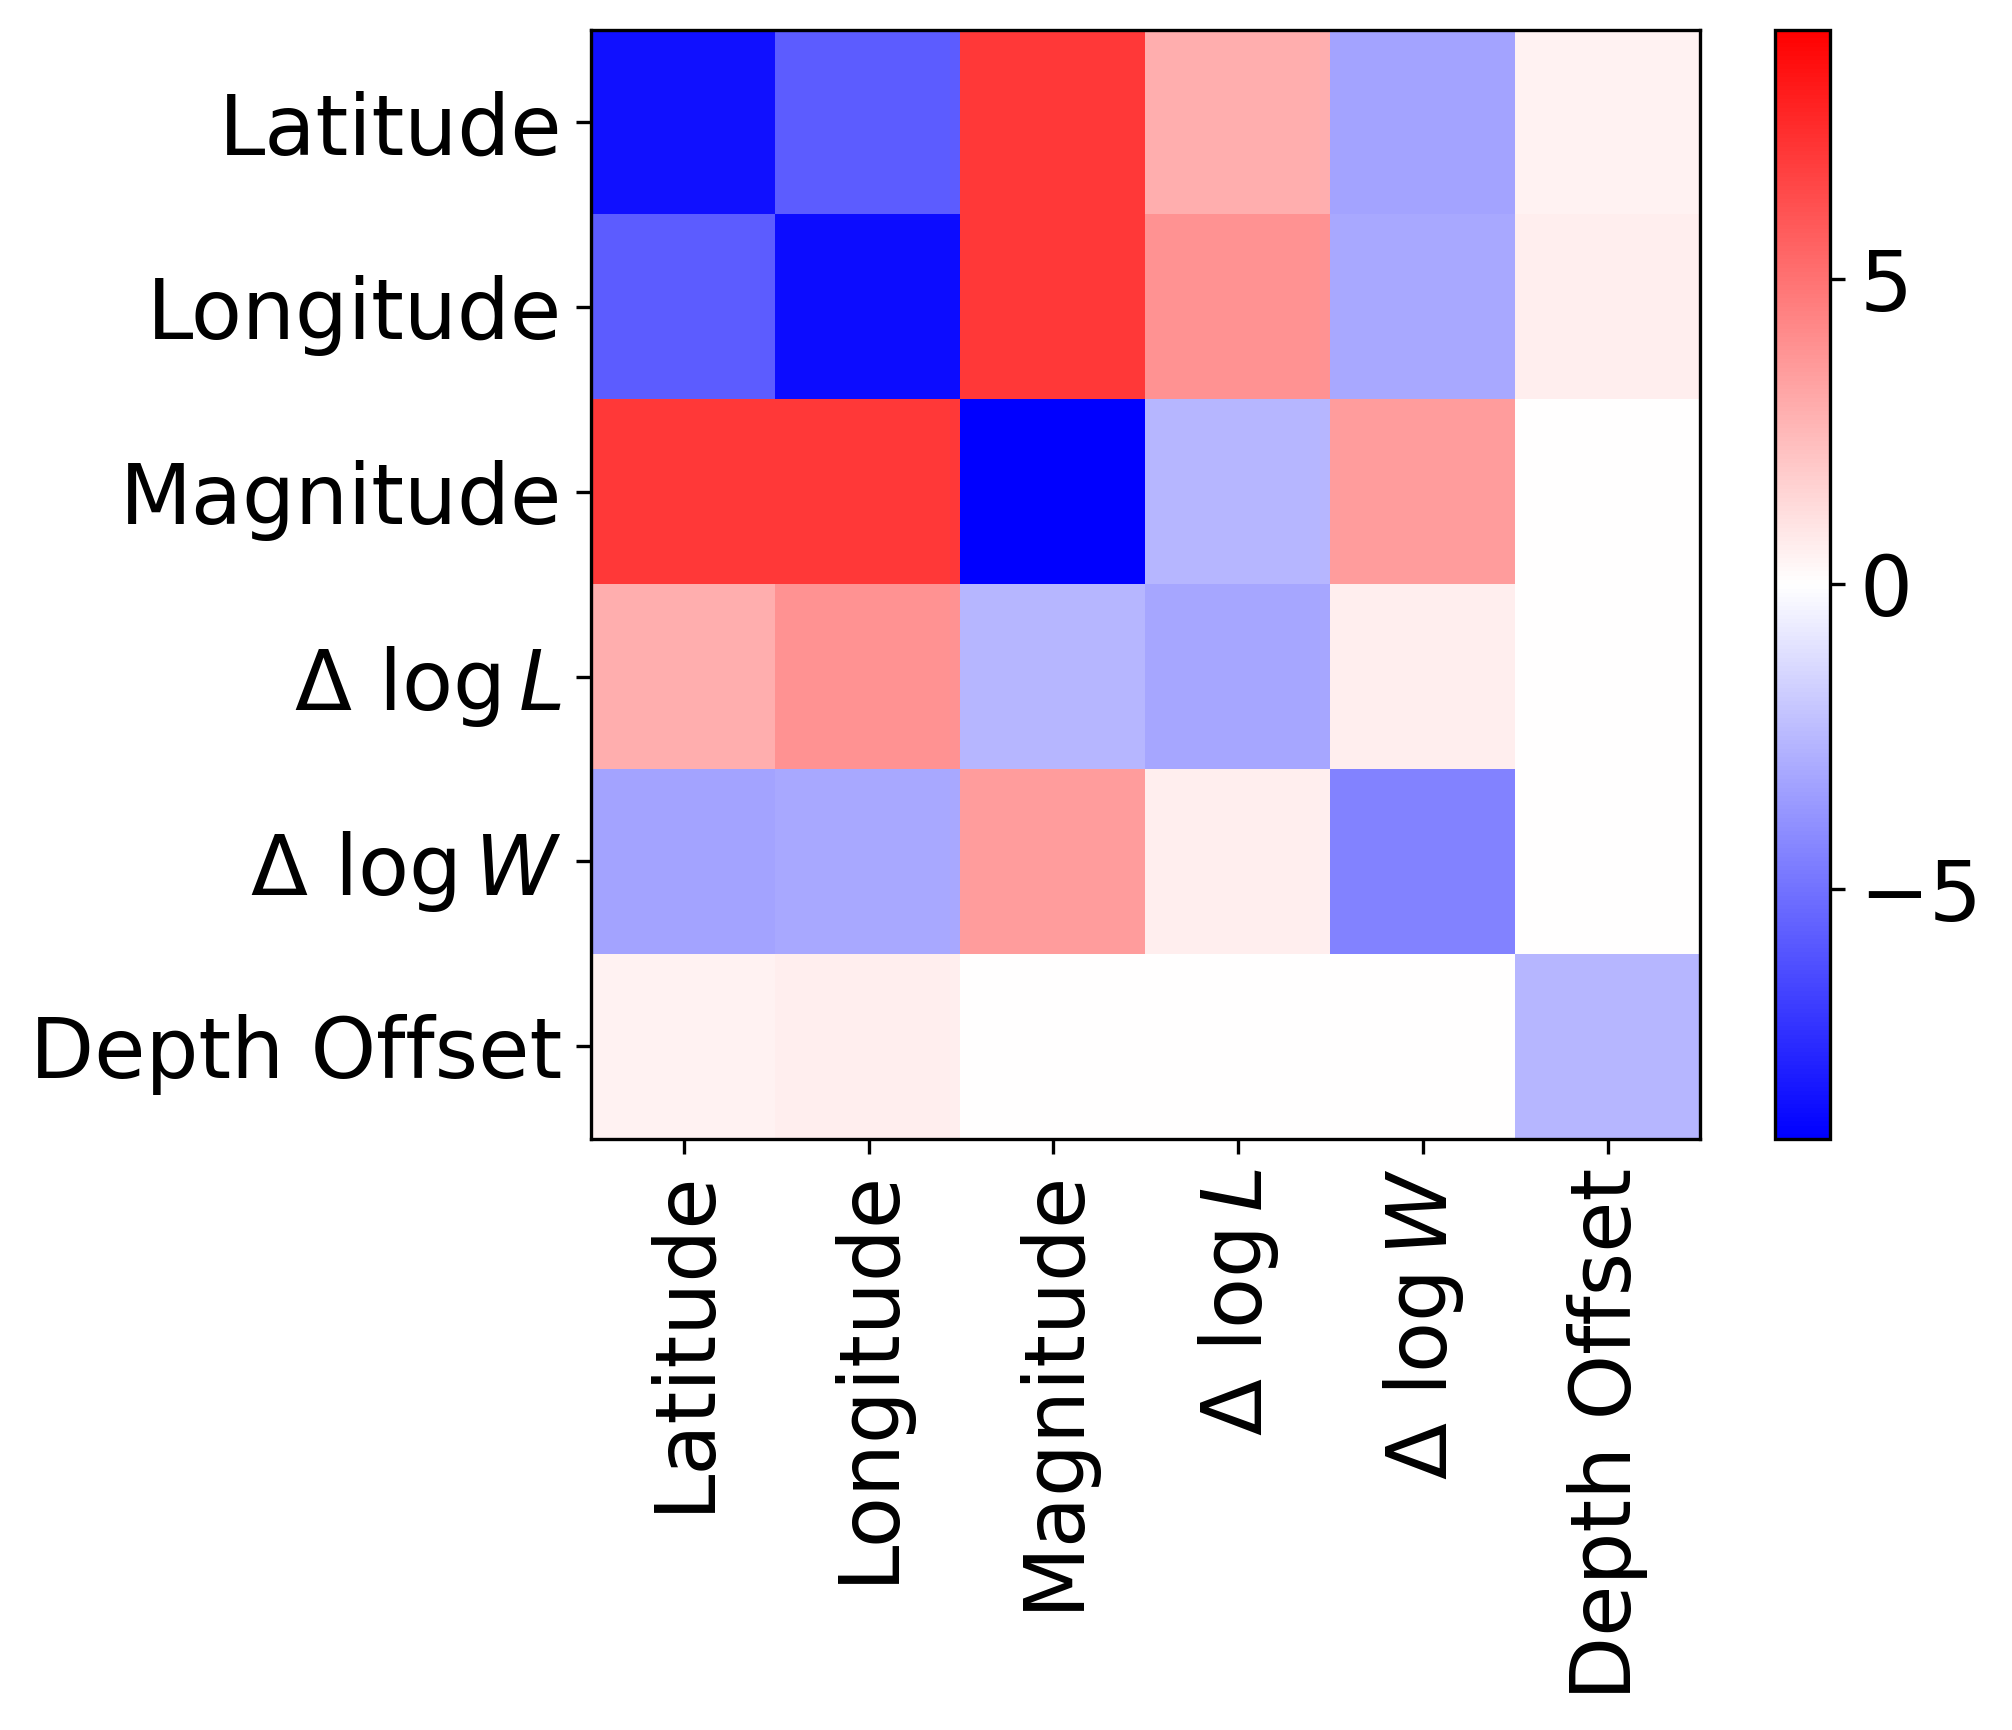

In [21]:
# Visualize the Hessian
plt.figure(dpi=300)
# plt.title("Hessian of the posterior at the MAP")
cbound = max([np.max(np.abs(Hopt)), np.min(np.abs(Hopt))])
plt.imshow(Hopt, vmin=-cbound, vmax=cbound, cmap="bwr")
clb = plt.colorbar()
clb.ax.tick_params(labelsize=20)
plt.xticks(range(nparams), param_labels, rotation=90, fontsize=20)
plt.yticks(range(nparams), param_labels, fontsize=20)
plt.savefig("hessian_estimate_1852.pdf", bbox_inches="tight")
plt.show()

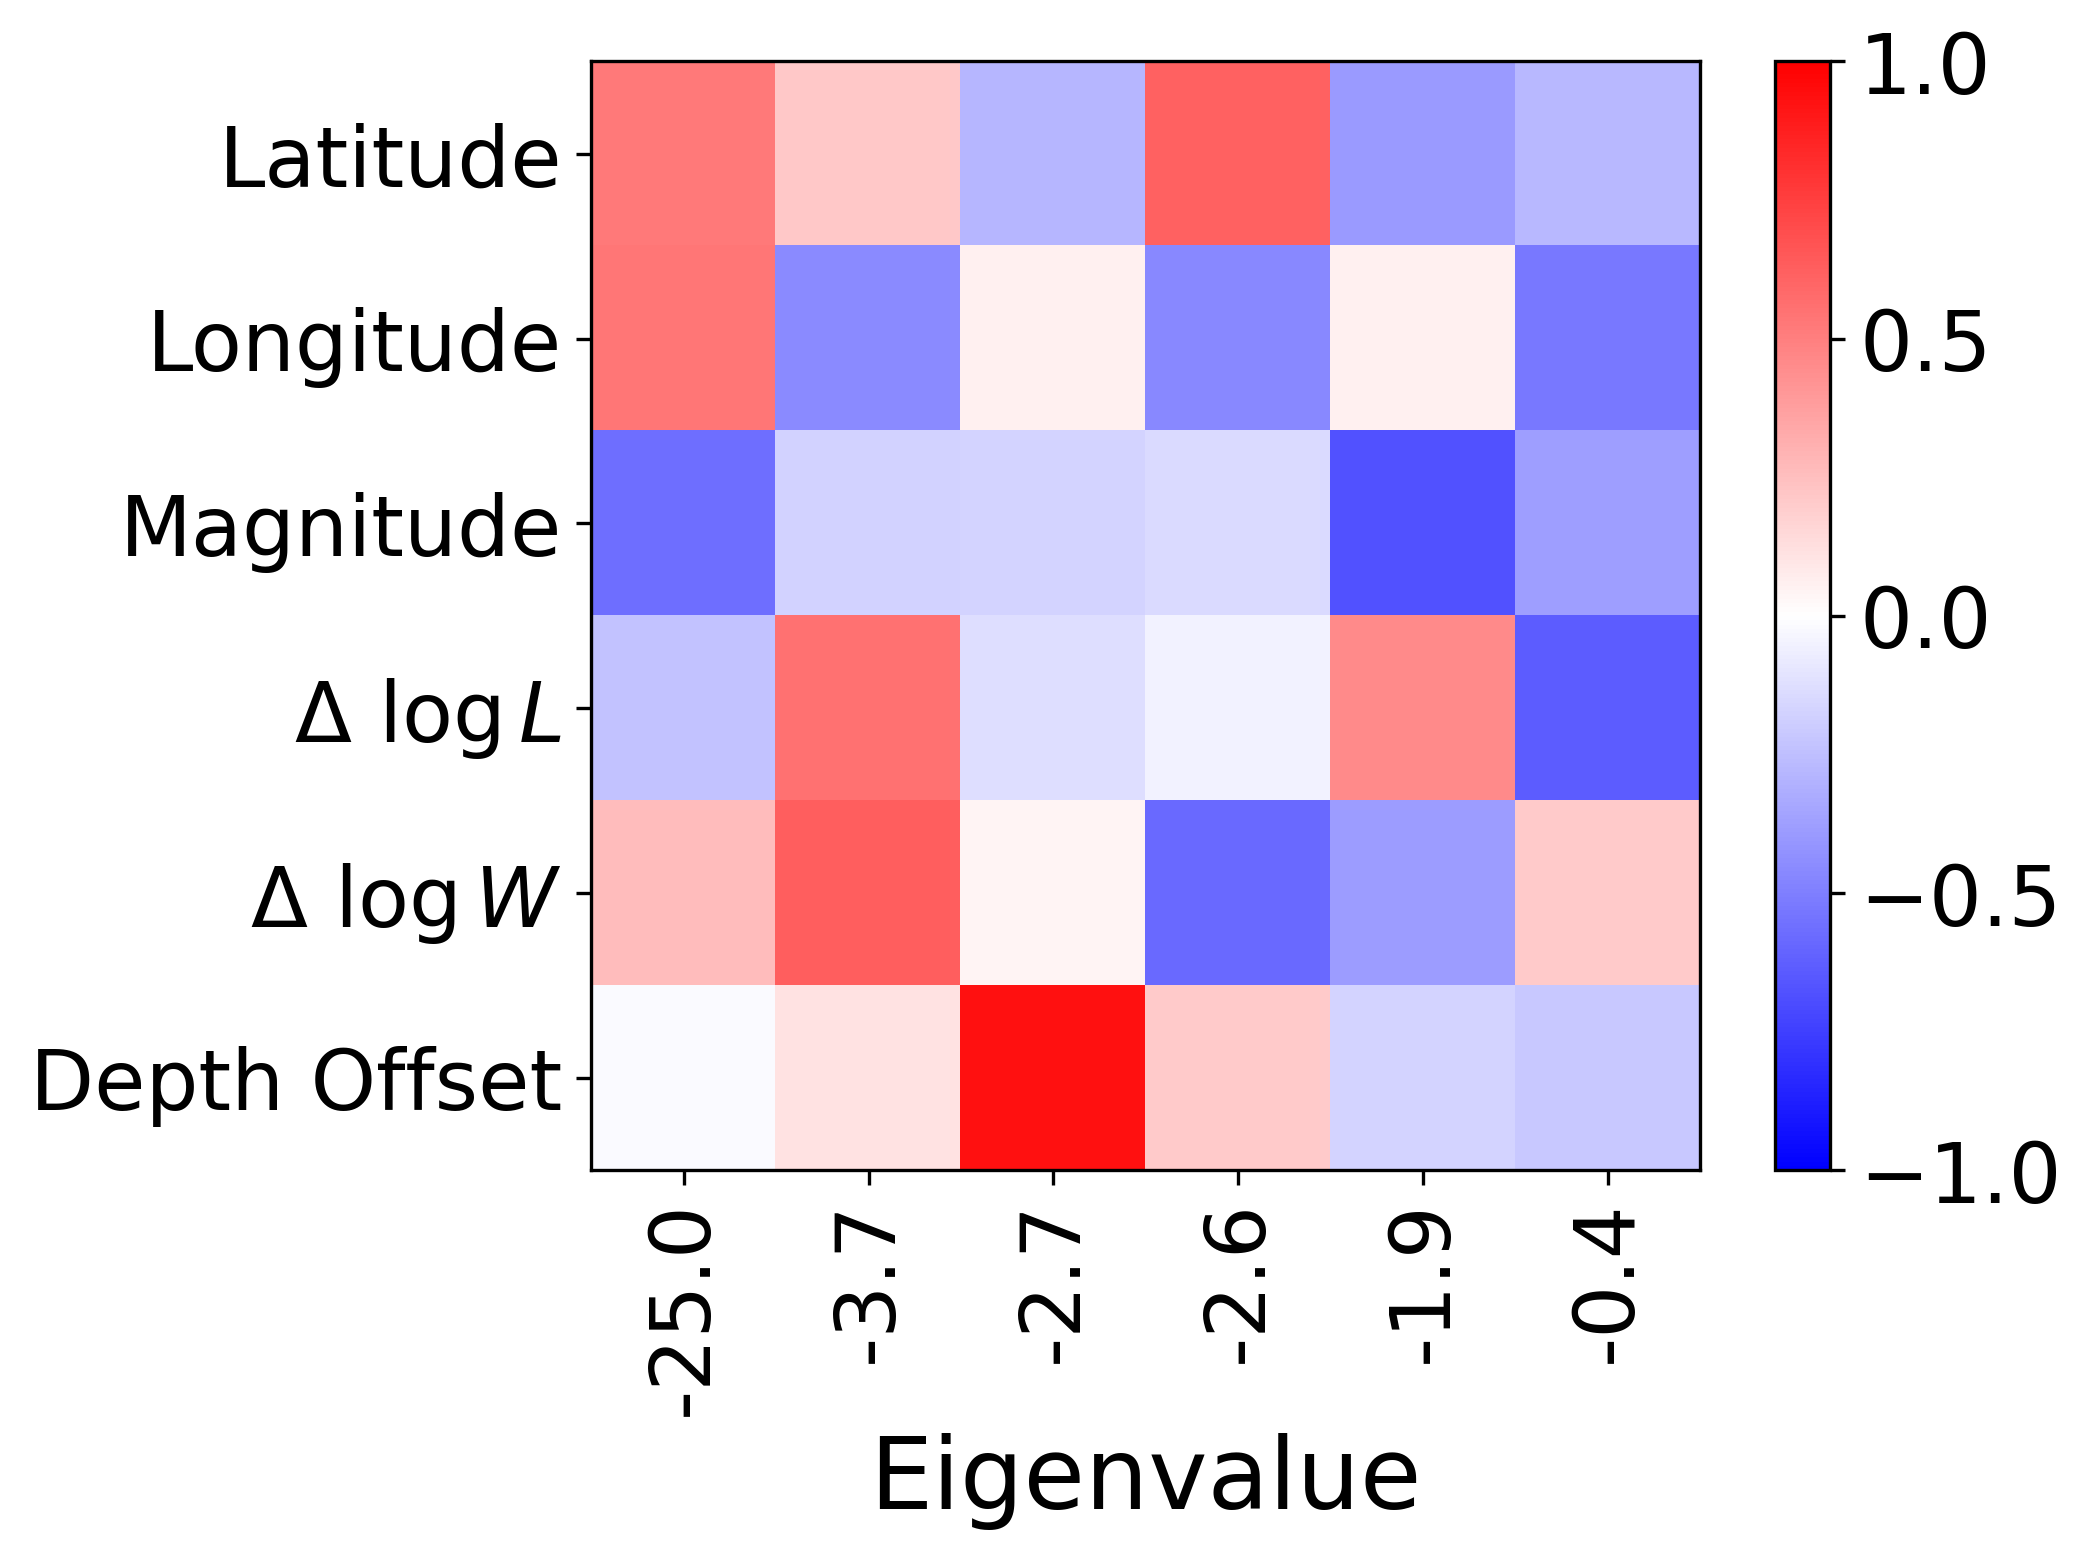

In [22]:
# Visualize the eigenvectors
plt.figure(dpi=300)
# plt.title("Eigenvectors of Hessian")
plt.imshow(eigvecs, vmin=-1, vmax=1, cmap="bwr")
plt.xticks(range(nparams), np.round(eigvals, 1), rotation=90, fontsize=20)
plt.yticks(range(nparams), param_labels, fontsize=20)
plt.xlabel("Eigenvalue", fontsize=24)
clb = plt.colorbar()
clb.ax.tick_params(labelsize=20)
plt.savefig("figures/hessian_estimate_eigenvectors_1852.pdf", bbox_inches="tight")
plt.show()

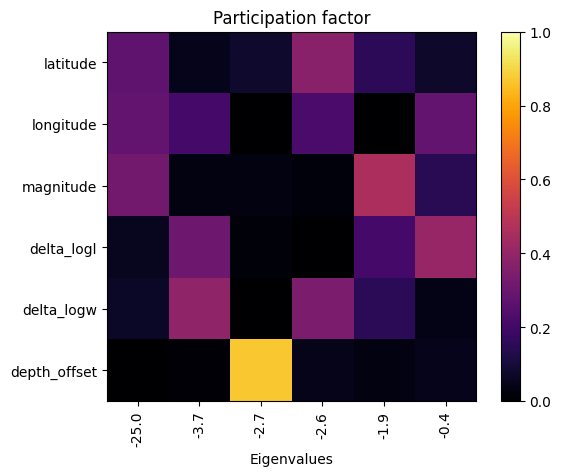

In [23]:
# Visualize the eigenvectors
plt.figure()
plt.title("Participation factor")
plt.imshow(eigvecs ** 2, vmin=0, vmax=1, cmap="inferno")
plt.xticks(range(nparams), np.round(eigvals, 1), rotation=90)
plt.yticks(range(nparams), param_names)
plt.xlabel("Eigenvalues")
plt.colorbar()
plt.show()

From the plot above, we see that the most sensitive direction to decrease the posterior is by moving the epicenter north-east and decreasing the magnitude.
This result actually makes sense.
We might want to look at the other eigenvectors, but notice that the magnitude of the eigenvalues corresponding to those vectors are way smaller compared to the dominant eigenvalue.

### Comparison to the correlation matrix

In [24]:
corr = np.cov(samples_normalized.T)

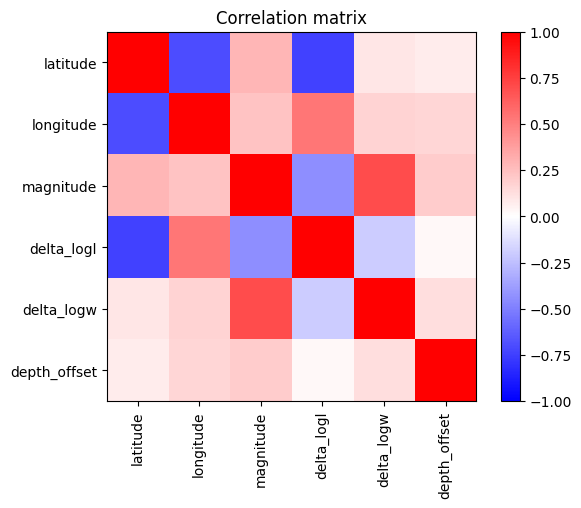

In [25]:
# Visualize the Hessian
plt.figure()
plt.title("Correlation matrix")
plt.imshow(corr, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks(range(nparams), param_names, rotation=90)
plt.yticks(range(nparams), param_names)
plt.show()

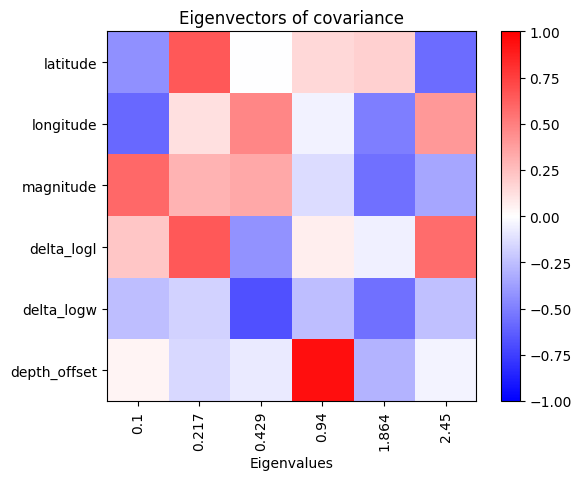

In [26]:
eigvals_corr, eigvecs_corr = np.linalg.eigh(corr)

# Visualize the eigenvectors
plt.figure()
plt.title("Eigenvectors of covariance")
plt.imshow(eigvecs_corr, vmin=-1, vmax=1, cmap="bwr")
plt.xticks(range(nparams), np.round(eigvals_corr, 3), rotation=90)
plt.yticks(range(nparams), param_names)
plt.xlabel("Eigenvalues")
plt.colorbar()
plt.show()

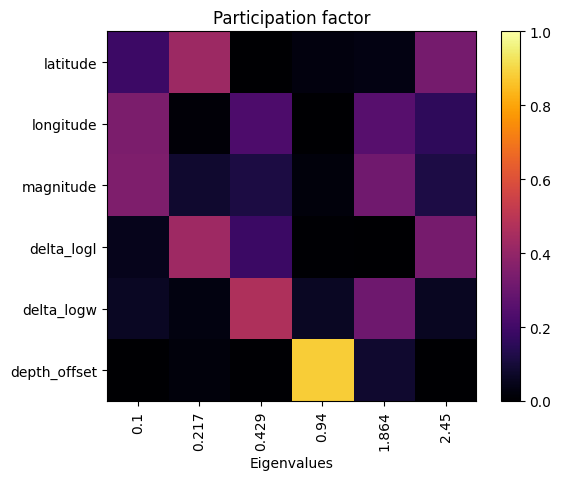

In [27]:
# Visualize the eigenvectors
plt.figure()
plt.title("Participation factor")
plt.imshow(eigvecs_corr ** 2, vmin=0, vmax=1, cmap="inferno")
plt.xticks(range(nparams), np.round(eigvals_corr, 3), rotation=90)
plt.yticks(range(nparams), param_names)
plt.xlabel("Eigenvalues")
plt.colorbar()
plt.show()

## Derivative estimation around the MLE

In [28]:
idx_mle = np.argmax(loglike_samples_flatten)

In [29]:
J_estimate_file = Path("results/J_mle_1852.pkl")

if J_estimate_file.exists():
    with open(J_estimate_file, "rb") as f:
        J_estimate_dict = pickle.load(f)
else:
    J_estimate_dict = {}

for r in tqdm(rlist):
    key = np.round(r, 1)
    if key not in J_estimate_dict:
        # try:
        J = compute_J(r, idx_mle)
        J_estimate_dict.update({key: {"jacobian": J}})
        
        # Export
        with open(J_estimate_file, "wb") as f:
            pickle.dump(J_estimate_dict, f, protocol=4)
        # except ValueError:
        #     break

100%|███████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 16855.01it/s]


### Visualize the samples used in the derivative estimation

In [30]:
# Get the index of samples
# Normalized samples
samples_normalized = normalize_samples(
    samples_flatten, samples_flatten[idx_mle], np.std(samples_flatten, axis=0)
)

# Only use points within a hypersphere in samples space
center = samples_normalized[idx_mle]
samples_norm_subset, idx_subset = get_samples_subset(samples_normalized, center, ropt)
print(len(idx_subset))

254


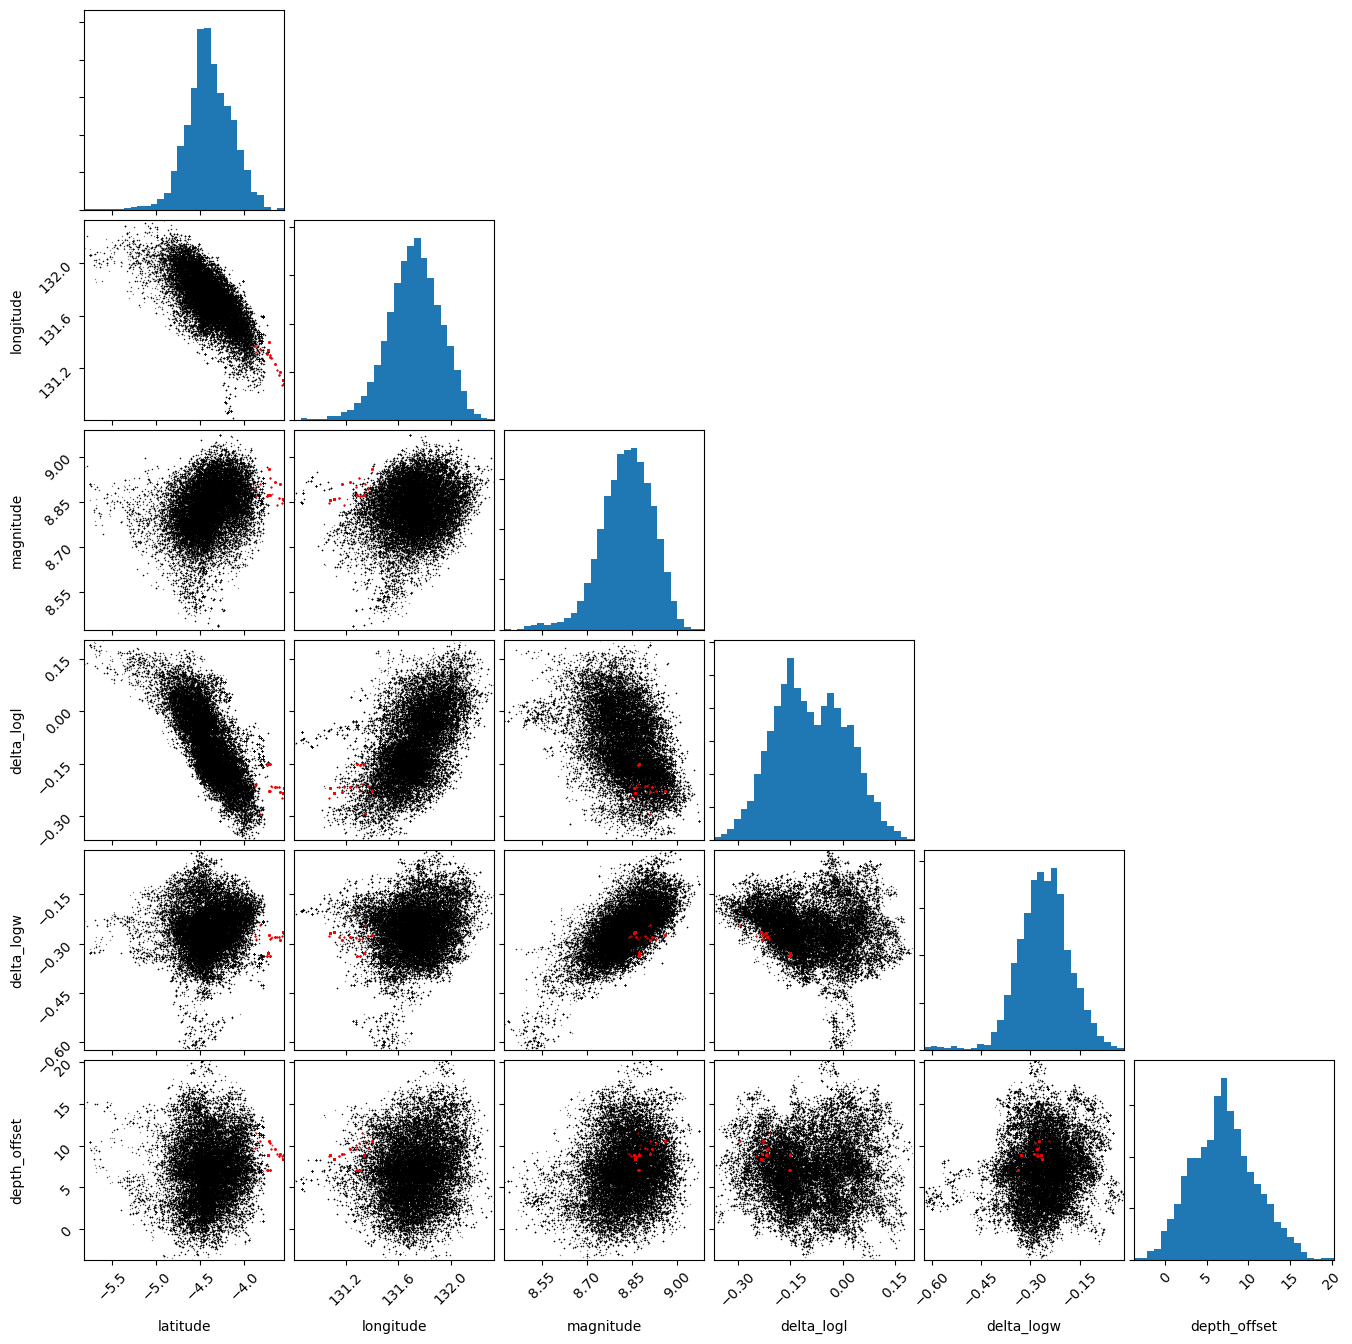

In [31]:
figure = corner(
    samples_flatten,
    labels=param_names,  # Name of parameters
    bins=30,  # Number of bins
    # kwargs for marginal distribution
    hist_kwargs=dict(color="tab:blue", histtype="stepfilled"),
    # kwargs for lower triangular plot(s)
    **dict(
        color="k",  # Color of samples, density, and contours
        plot_density=False,  # Flag to deactivate the density plot
        plot_contours=False,  # Flag to deactivate the contour plot
        data_kwargs=dict(ms=1, alpha=0.5),  # Other kwargs to plot samples
    ),
)

axes = np.array(figure.axes).reshape((nparams, nparams))
for row in range(nparams):
    for col in range(nparams):
        if col < row:
            ax = axes[row, col]
            ax.plot(
                *(samples_flatten[idx_subset][:, [col, row]].T), "r.", ms=1, alpha=0.5
            )
plt.show()

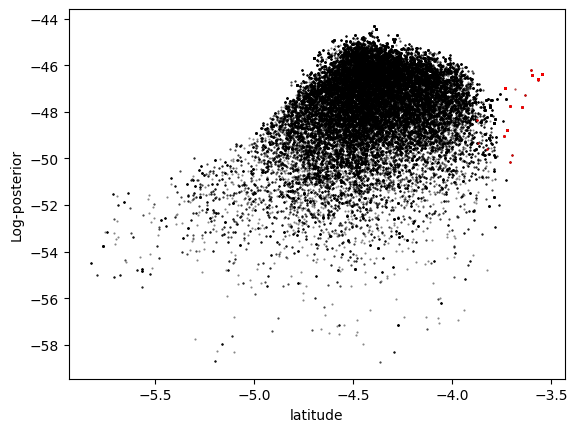

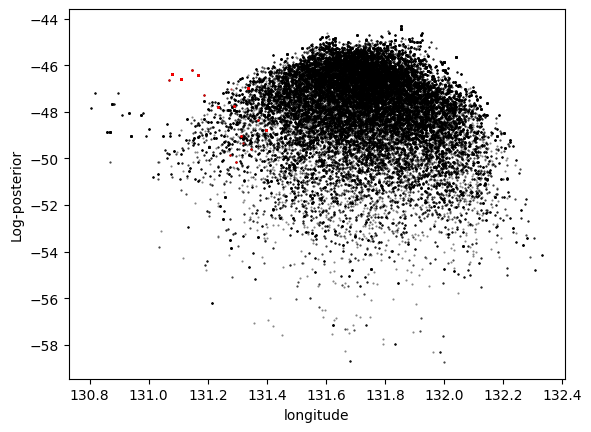

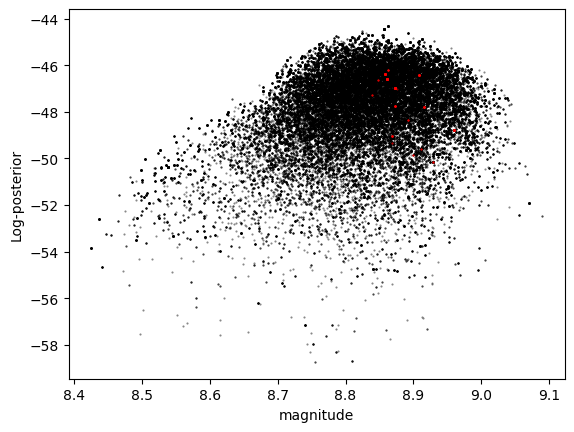

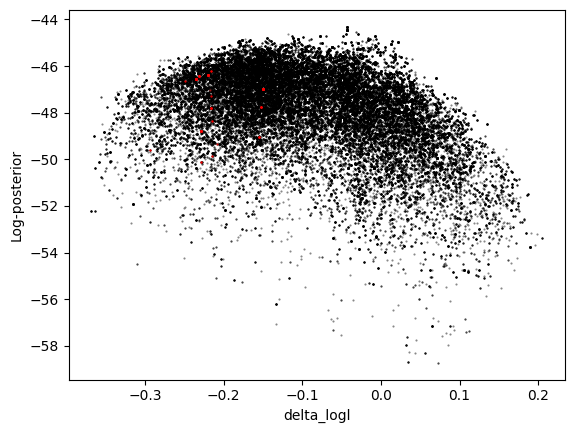

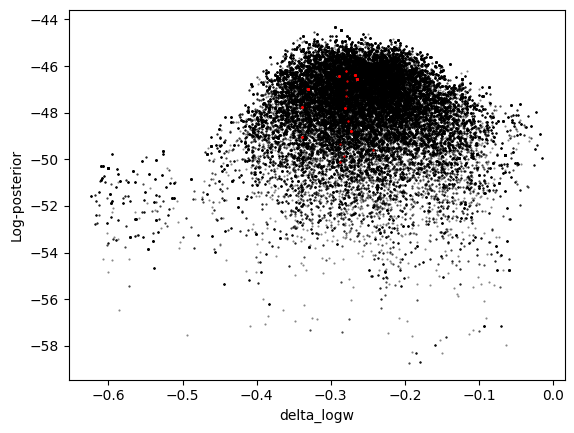

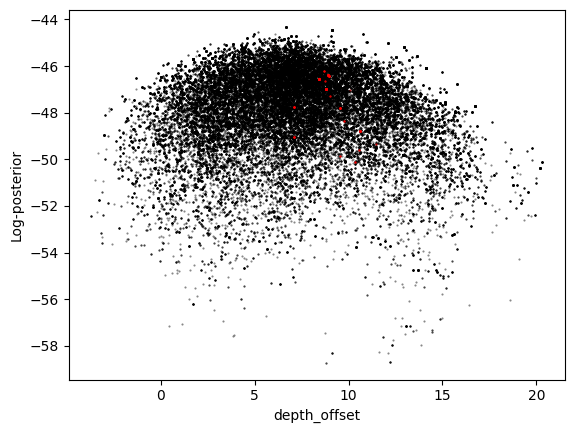

In [32]:
for ii, name in enumerate(param_names):
    plt.figure()
    plt.plot(samples_flatten[:, ii], logpost_samples_flatten, "k.", ms=1, alpha=0.5)
    plt.plot(
        samples_flatten[idx_subset, ii],
        logpost_samples_flatten[idx_subset],
        "r.",
        ms=1,
        alpha=0.5,
    )
    plt.xlabel(name)
    plt.ylabel("Log-posterior")
plt.show()

### Analysis of the estimated derivative

In [33]:
# Get the Jacobian estimated
Jmle = J_estimate_dict[ropt]["jacobian"]

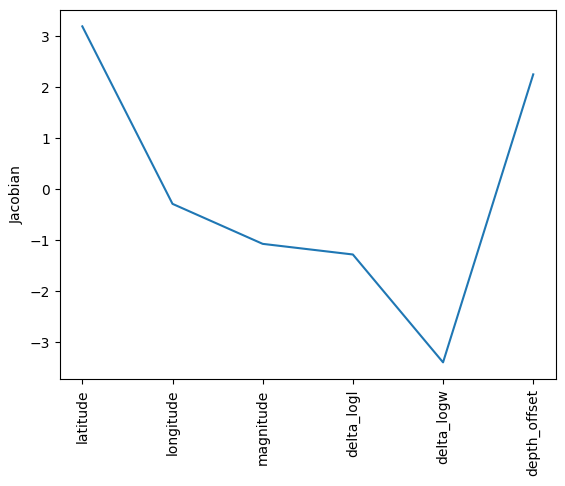

In [34]:
# Visualize the Jacobian
plt.figure()
plt.plot(Jmle.flatten())
plt.xticks(range(nparams), param_names, rotation=90)
plt.ylabel("Jacobian")
plt.show()